In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cadaster = pd.read_csv("data/cadaster_1808.csv")

In [3]:
list_family_names = pd.read_csv("data/Venice_list_of_names.csv", sep='\t"')

list_family_names = list_family_names.apply(lambda x: x.str.replace("\"", ""))

list_family_names.columns = [ 'family', '1808', 'Noble', 'Citoyen', 'famille.12e.siecle']

list_family_names.index = list_family_names.index.map(lambda x: x.replace("\"", ""))

list_family_names.to_csv("data/venice_families_cleaned.csv")

<ipython-input-3-646beb43eb24>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  list_family_names = pd.read_csv("data/Venice_list_of_names.csv", sep='\t"')


In [4]:
list_family_names

,family,1808,Noble,Citoyen,famille.12e.siecle
1,abramo,0,NA,0,0
2,acotanto,0,1,0,0
3,acquisti,1,1,0,0
4,adami,1,1,1,0
5,adoaldi,0,1,0,0
...,...,...,...,...,...
4459,cortonovich,1,0,0,0
4460,zanutta,1,0,0,0
4461,manfrini,1,0,0,0
4462,bardini,1,0,0,0


### Extracting the family names in capital letters


In [5]:
capitals = cadaster.parcelOwnerText.str.extract(r'(?P<Names>[A-Z]{2,})')
capitals['Names'].apply(lambda x : len(str(x).split(" ")))
capitals

,Names
0,PAGANI
1,TIEPOLO
2,PAGANI
3,BELLI
4,TIEPOLO
...,...
23423,PIAZZA
23424,DEMANIO
23425,REGIO
23426,DEMANIO


In [6]:
capitals.groupby('Names')['Names'].count().sort_values(ascending=False)

Names
CITTA        652
COMUNE       413
MOROSINI     280
CONTARINI    245
CORNER       218
            ... 
FOSCARIN       1
SALA           1
FORTUNIO       1
FORNONI        1
SEGREGO        1
Name: Names, Length: 2196, dtype: int64

In [7]:
df = capitals[capitals['Names'].str.lower().isin(list_family_names.family)]

In [8]:
df.groupby('Names')['Names'].count().sort_values(ascending=False)

Names
CITTA        652
COMUNE       413
MOROSINI     280
CONTARINI    245
CORNER       218
            ... 
FORTUNIO       1
FORNONI        1
SALA           1
SALAROL        1
LIVIO          1
Name: Names, Length: 2185, dtype: int64

In [9]:
public_names = 'citta|demanio|chiesa|piazza|ministero|comune|societa|congregazione|di'
non_public = df[~df.Names.str.contains(public_names, na=False, case=False)]
name_count_cadaster = non_public.groupby('Names')['Names'].count().sort_values(ascending=False)

In [10]:
name_count_cadaster.to_csv('data/names_cadaster.csv')

## Catastici

In [11]:
catastici = pd.read_csv('data/catastici_1741_cleaned.csv')

In [59]:
family_name_options = list_family_names['family'].values

catastici['entryOwnerText_l'] = catastici['entryOwnerText'].apply(lambda x: str(x).lower())
catastici['entryTenantText_l'] = catastici['entryTenantText'].apply(lambda x: str(x).lower())



In [35]:
# we will use a fuzzy ratio to extract the name
from fuzzywuzzy import fuzz, process

top_3_names = catastici['entryOwnerText_l'].apply(lambda x: process.extract(x,family_name_options, scorer=fuzz.token_set_ratio, limit = 3))


In [60]:
tenant_name = catastici['entryTenantText_l'].apply(lambda x: process.extractOne(x,family_name_options, scorer=fuzz.token_set_ratio))


In [61]:
tenant_name.to_csv("tenant_names.csv")

In [63]:
catastici['tenant'] = pd.DataFrame(tenant_name)

In [57]:
owner_3 = ['owner_name1','owner_name2','owner_name3']
catastici[owner_3] = pd.DataFrame(top_3_names)['entryOwnerText_l'].apply(lambda x: pd.Series(x))

In [58]:
for col in owner_3:
    catastici[col] = catastici[col].apply(lambda x: x[0] if x[1] > 95 else None)
    catastici[col] = catastici[col].apply(lambda x: x if x != 'di' and x != 'de' else None)

In [64]:
catastici['tenant'] = catastici['tenant'].apply(lambda x: x[0])

In [65]:
melted = catastici.melt(id_vars = ['id', 'entryId', 'entryOwnerText', 'entryTenantText',
       'entryCategoryText', 'rent', 'cadaster1808Correspondance', 'toponym',
       'entryCategories', 'cadaster1808ClosestParcel', 'position',
       'entryOwnerText_l','tenant']).dropna(subset=['value'])

In [80]:
melted['family_owner_count'] = melted.groupby('value')['id'].transform('count')

In [84]:
melted['family_tenant_count'] = melted.groupby('tenant')['id'].transform('count')

In [85]:
melted['family_tenant_count']

2         126
3         121
4          53
5         431
6          46
         ... 
68049      79
68050      16
68051       5
68052    2495
68053       1
Name: family_tenant_count, Length: 35100, dtype: int64

In [86]:
melted

,id,entryId,entryOwnerText,entryTenantText,entryCategoryText,rent,cadaster1808Correspondance,toponym,entryCategories,cadaster1808ClosestParcel,position,entryOwnerText_l,tenant,variable,value,family_count,family_tenant_count
2,2,207.0,Alessandro Buffetti,Cristofolo Fianello,"Casa, primo appartamento",20.0,NaN,Calle Galliazza,['housing'],13268,"[12.33680766, 45.43745093]",alessandro buffetti,cristofoli,name1,buffetti,30,126
3,3,207.0,Alessandro Buffetti,Per uso del padrone,"Casa, secondo appartamento",NaN,NaN,Calle Galliazza,['housing'],13268,"[12.3368313, 45.43744348]",alessandro buffetti,del,name1,buffetti,30,121
4,4,207.0,Alessandro Buffetti,Inaffittato,"Casa, terzo appartamento",30.0,NaN,Calle Galliazza,['housing'],13268,"[12.33685662, 45.43743407]",alessandro buffetti,pinaffo,name1,buffetti,30,53
5,5,208.0,Alessandro Buffetti,Carlo Pezzi,Magazen,12.0,NaN,Calle Galliazza,['storage'],13268,"[12.336876759999999, 45.43742819]",alessandro buffetti,carlo,name1,buffetti,30,431
6,6,210.0,Alessandro Buffetti,Piero Baroni,Magazen,NaN,NaN,Calle Galliazza,['storage'],13268,"[12.3369179, 45.43741493]",alessandro buffetti,baroni,name1,buffetti,30,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68049,9717,105.0,Francesco e Zuanne fratelli Moro,Domenico Fabris,Casa in cinque fitanze,14.0,10105.0,Calletta della Torre,['housing'],10105,"[12.33397622, 45.4393669]",francesco e zuanne fratelli moro,fabris,entryTenantText_l,domenico fabris,6,79
68050,9718,105.0,Francesco e Zuanne fratelli Moro,Domenica Capellari,Casa in cinque fitanze,6.0,10105.0,Calletta della Torre,['housing'],10105,"[12.3339705, 45.43936174]",francesco e zuanne fratelli moro,capellari,entryTenantText_l,domenica capellari,1,16
68051,9719,105.0,Francesco e Zuanne fratelli Moro,Adamo Fachin,Casa in cinque fitanze,10.0,10105.0,Calletta della Torre,['housing'],10105,"[12.33396503, 45.4393554]",francesco e zuanne fratelli moro,da fin,entryTenantText_l,adamo fachin,1,5
68052,9720,166.0,Lugrezia Porta Guazzo Zia de Marchio e Fratell...,NaN,Per altra porzione di Casa,21.0,512.0,Calle di Ca' Corner,['housing'],512,"[12.32959686, 45.43466271]",lugrezia porta guazzo zia de marchio e fratell...,nani,entryTenantText_l,nan,803,2495


In [89]:
morosini = melted[melted['value'] == 'morosini'].groupby('tenant').agg({'id':'count','family_tenant_count':'mean'})

In [91]:
morosini['proportion_of_rentals'] = morosini['id'] / morosini['family_tenant_count']

<ipython-input-99-d1051a1a3bbb>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(for_plot.index,rotation = 90)


[Text(0, 0, 'gidoni'),
 Text(1, 0, 'brini'),
 Text(2, 0, 'ronzoni'),
 Text(3, 0, 'greco'),
 Text(4, 0, 'agrinali'),
 Text(5, 0, 'grassianceli'),
 Text(6, 0, 'coreggio'),
 Text(7, 0, 'epis'),
 Text(8, 0, 'mazzamano'),
 Text(9, 0, 'maistrorso'),
 Text(10, 0, 'stae'),
 Text(11, 0, 'pagan'),
 Text(12, 0, 'gerlin'),
 Text(13, 0, 'gagio'),
 Text(14, 0, 'morari'),
 Text(15, 0, 'persego'),
 Text(16, 0, 'satelico'),
 Text(17, 0, 'boniol'),
 Text(18, 0, 'megliorini'),
 Text(19, 0, 'bocchini')]

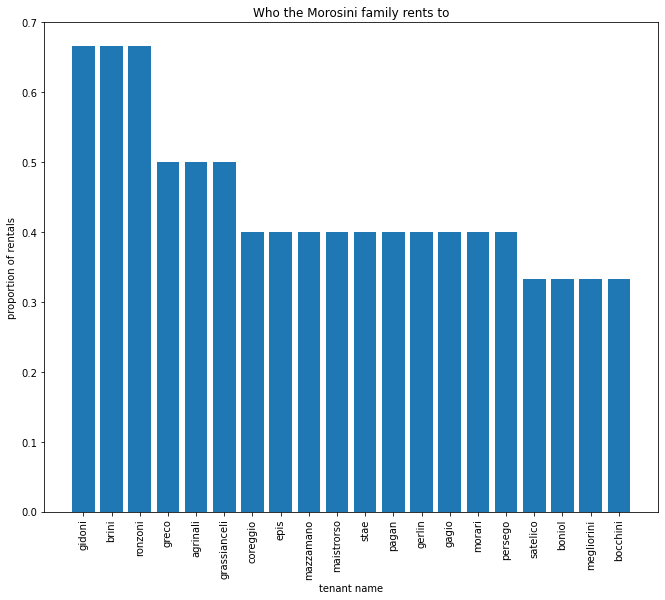

In [99]:
for_plot = morosini.sort_values(by = 'proportion_of_rentals',ascending=False).head(20)
fig, ax = plt.subplots(figsize=(11,9))
ax.bar(for_plot.index,for_plot['proportion_of_rentals'])
ax.set_xlabel("tenant name")
ax.set_ylabel("proportion of rentals")
ax.set_title("Who the Morosini family rents to")
ax.set_xticklabels(for_plot.index,rotation = 90)

In [101]:
melted.groupby('value')['area'].sum()

,id,entryId,entryOwnerText,entryTenantText,entryCategoryText,rent,cadaster1808Correspondance,toponym,entryCategories,cadaster1808ClosestParcel,position,entryOwnerText_l,tenant,variable,value,family_count,family_tenant_count
2,2,207.0,Alessandro Buffetti,Cristofolo Fianello,"Casa, primo appartamento",20.0,NaN,Calle Galliazza,['housing'],13268,"[12.33680766, 45.43745093]",alessandro buffetti,cristofoli,name1,buffetti,30,126
3,3,207.0,Alessandro Buffetti,Per uso del padrone,"Casa, secondo appartamento",NaN,NaN,Calle Galliazza,['housing'],13268,"[12.3368313, 45.43744348]",alessandro buffetti,del,name1,buffetti,30,121
4,4,207.0,Alessandro Buffetti,Inaffittato,"Casa, terzo appartamento",30.0,NaN,Calle Galliazza,['housing'],13268,"[12.33685662, 45.43743407]",alessandro buffetti,pinaffo,name1,buffetti,30,53
5,5,208.0,Alessandro Buffetti,Carlo Pezzi,Magazen,12.0,NaN,Calle Galliazza,['storage'],13268,"[12.336876759999999, 45.43742819]",alessandro buffetti,carlo,name1,buffetti,30,431
6,6,210.0,Alessandro Buffetti,Piero Baroni,Magazen,NaN,NaN,Calle Galliazza,['storage'],13268,"[12.3369179, 45.43741493]",alessandro buffetti,baroni,name1,buffetti,30,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68049,9717,105.0,Francesco e Zuanne fratelli Moro,Domenico Fabris,Casa in cinque fitanze,14.0,10105.0,Calletta della Torre,['housing'],10105,"[12.33397622, 45.4393669]",francesco e zuanne fratelli moro,fabris,entryTenantText_l,domenico fabris,6,79
68050,9718,105.0,Francesco e Zuanne fratelli Moro,Domenica Capellari,Casa in cinque fitanze,6.0,10105.0,Calletta della Torre,['housing'],10105,"[12.3339705, 45.43936174]",francesco e zuanne fratelli moro,capellari,entryTenantText_l,domenica capellari,1,16
68051,9719,105.0,Francesco e Zuanne fratelli Moro,Adamo Fachin,Casa in cinque fitanze,10.0,10105.0,Calletta della Torre,['housing'],10105,"[12.33396503, 45.4393554]",francesco e zuanne fratelli moro,da fin,entryTenantText_l,adamo fachin,1,5
68052,9720,166.0,Lugrezia Porta Guazzo Zia de Marchio e Fratell...,NaN,Per altra porzione di Casa,21.0,512.0,Calle di Ca' Corner,['housing'],512,"[12.32959686, 45.43466271]",lugrezia porta guazzo zia de marchio e fratell...,nani,entryTenantText_l,nan,803,2495


In [39]:
#Getting all owner rows with only two words (hoping that it's name and surname)
name_surname = catastici.entryOwnerText.apply(lambda x: len(str(x).split(' ')) == 2)

In [40]:
catastici[name_surname].groupby('entryOwnerText')['id'].count().sort_values(ascending=False)

entryOwnerText
Francesco Foscari       46
Michiel Morosini        46
Zuanne Pasqualigo       36
Marc'Antonio Grimani    32
Marin Bernardo          31
                        ..
Francesco Rubbi          1
Francesco Rota           1
Francesco Polverini      1
Francesco Pasta          1
diversi consorti         1
Name: id, Length: 1601, dtype: int64

In [41]:
catastici_names = catastici[name_surname]

In [42]:
catastici_names['owner_surname'] = catastici_names.entryOwnerText.apply(lambda x: str(x).split()[1])
catastici_names['owner_name'] = catastici_names.entryOwnerText.apply(lambda x: str(x).split()[0])

<ipython-input-42-3e1b65f7341e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catastici_names['owner_surname'] = catastici_names.entryOwnerText.apply(lambda x: str(x).split()[1])
<ipython-input-42-3e1b65f7341e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catastici_names['owner_name'] = catastici_names.entryOwnerText.apply(lambda x: str(x).split()[0])


In [43]:
catastici_names

,id,entryId,entryOwnerText,entryTenantText,entryCategoryText,rent,cadaster1808Correspondance,toponym,entryCategories,cadaster1808ClosestParcel,position,owner_surname,owner_name
2,2,207.0,Alessandro Buffetti,Cristofolo Fianello,"Casa, primo appartamento",20.0,NaN,Calle Galliazza,['housing'],13268,"[12.33680766, 45.43745093]",Buffetti,Alessandro
3,3,207.0,Alessandro Buffetti,Per uso del padrone,"Casa, secondo appartamento",NaN,NaN,Calle Galliazza,['housing'],13268,"[12.3368313, 45.43744348]",Buffetti,Alessandro
4,4,207.0,Alessandro Buffetti,Inaffittato,"Casa, terzo appartamento",30.0,NaN,Calle Galliazza,['housing'],13268,"[12.33685662, 45.43743407]",Buffetti,Alessandro
5,5,208.0,Alessandro Buffetti,Carlo Pezzi,Magazen,12.0,NaN,Calle Galliazza,['storage'],13268,"[12.336876759999999, 45.43742819]",Buffetti,Alessandro
6,6,210.0,Alessandro Buffetti,Piero Baroni,Magazen,NaN,NaN,Calle Galliazza,['storage'],13268,"[12.3369179, 45.43741493]",Buffetti,Alessandro
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9697,9697,292.0,Daniel Giustinian,Antonio Strina,Casa,11.0,NaN,Campiel de Tedeschi,['housing'],13268,"[12.3291891, 45.43379258]",Giustinian,Daniel
9701,9701,297.0,Nicolò Corner,Gerolemo Todeschini,Casa,30.0,NaN,Campiel de Tedeschi,['housing'],13268,"[12.32911497, 45.43381953]",Corner,Nicolò
9702,9702,298.0,Nicolò Corner,Antonia Gerardi,Casa,8.0,NaN,Campiel de Tedeschi,['housing'],13268,"[12.32909029, 45.43381123]",Corner,Nicolò
9703,9703,299.0,Nicolò Corner,Giacomo Menegetti,Casa,12.0,NaN,Campiel de Tedeschi,['housing'],13268,"[12.32907088, 45.43379092]",Corner,Nicolò


In [53]:
catastici_names.to_csv('data/names_catastici.csv')

In [44]:
name_count_catastici = catastici_names.groupby('owner_surname')['id'].count().sort_values(ascending=False)

In [45]:
name_count_catastici

owner_surname
Contarini     95
Morosini      91
Grimani       77
Donà          75
Corner        71
              ..
Gregoletti     1
Gregorin       1
Grotta         1
Grotto         1
verde          1
Name: id, Length: 906, dtype: int64

## Which families own the most properties?

In [46]:
top_fams_catastici = name_count_catastici.head(25)
top_fams_catastici

owner_surname
Contarini     95
Morosini      91
Grimani       77
Donà          75
Corner        71
Venier        70
Pisani        66
Querini       64
Cassetti      57
Giustinian    54
Mocenigo      51
Foscari       49
Gritti        47
Barbarigo     47
Zen           47
Pasqualigo    45
Priuli        45
Molin         44
Capello       42
Bernardo      39
Soranzo       39
Dandolo       36
Trevisan      35
Foscarini     34
Tron          33
Name: id, dtype: int64

In [47]:
top_fams_cadaster = name_count_cadaster.head(25)
top_fams_cadaster

Names
MOROSINI      280
CONTARINI     245
CORNER        218
CAPITOLO      195
DONA          195
GRIMANI       181
FOSCARINI     176
DOLFIN        167
PISANI        166
ZEN           155
VENIER        150
MOCENIGO      141
PRIULI        140
GRADENIGO     138
GIUSTINIAN    132
MORO          113
MOLIN         110
QUERINI       109
BALBI         108
RENIER         99
ALBRIZZI       91
BARBARO        89
BRAGADIN       85
SAGREDO        84
TIEPOLO        84
Name: Names, dtype: int64

In [48]:
contarini = catastici_names[catastici_names.owner_surname.apply(lambda x : 'Contarini' in x)]

In [49]:
contarini

,id,entryId,entryOwnerText,entryTenantText,entryCategoryText,rent,cadaster1808Correspondance,toponym,entryCategories,cadaster1808ClosestParcel,position,owner_surname,owner_name
53,53,230.0,Angelo Contarini,Giovanni Battista Galvan,Bottega,32.0,2027.0,Calle de Stagneri,['shop'],2027,"[12.33706352, 45.43726575]",Contarini,Angelo
54,54,231.0,Angelo Contarini,Zuanne Boldon,Bottega,36.0,2027.0,Calle de Stagneri,['shop'],2027,"[12.33709071, 45.43725817]",Contarini,Angelo
55,55,232.0,Angelo Contarini,Zuanne Redolfi,Bottega,50.0,2027.0,Calle de Stagneri,['shop'],2027,"[12.33711791, 45.43725059]",Contarini,Angelo
210,210,52.0,Marco Contarini,Gaetano Bertoli,bottega da muschier e soler e casa in soler,94.0,NaN,Frezzaria,"['housing', 'shop', 'storage']",13268,"[12.3364587, 45.43362602]",Contarini,Marco
211,211,53.0,Marco Contarini,Antonio Dadie,Bottega di remessi e casa in tre soleri,92.0,1076.0,Frezzaria,"['housing', 'shop']",1076,"[12.33645101, 45.43365105]",Contarini,Marco
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7911,7911,272.0,Simon Contarini,Marina CImentona,"Casa in tre soleri, secondo soler",12.0,NaN,Corte delle Scalle,"['housing', 'storage']",13268,"[12.32683132, 45.43634474]",Contarini,Simon
7912,7912,273.0,Simon Contarini,Marina Schiauta,"Casa in tre soleri, terzo soler",3.0,NaN,Corte delle Scalle,"['housing', 'storage']",13268,"[12.32683286, 45.43633452]",Contarini,Simon
7913,7913,274.0,Simon Contarini,Mustachio Pilon,"Casa in tre soleri, terzo soler",5.0,NaN,Corte delle Scalle,"['housing', 'storage']",13268,"[12.3268253, 45.43633659]",Contarini,Simon
8565,8565,254.0,Alessandro Contarini,Iseppo Sabbini,Casa,140.0,NaN,Giù del Ponte della Mandollina,['housing'],13268,"[12.33319466, 45.43489198]",Contarini,Alessandro


In [51]:
contarini.to_json("data/contarini.json")

In [50]:
contarini_boys = contarini.groupby('owner_name')['id'].count().sort_values(ascending=False)
contarini_boys

owner_name
Simon          17
Marco          14
Alvise         14
Alessandro     13
Francesco       4
Zuanne          4
Angelo          3
Maria           3
Marin           2
Paolo           2
Cremesina       2
Battista        1
Vincenzo        1
Procuratore     1
Pietro          1
Piero           1
Otavian         1
Michiel         1
Marietta        1
Antonio         1
Anzolo          1
Grassia         1
Giulio          1
Giorgio         1
Giacomo         1
Aurelio         1
Fantini         1
Huomini         1
Name: id, dtype: int64

list